---
**Dataset:** *Coral reef global bleaching*


**Objective:** *Predict reef bleaching*

**Author:** *Danylo Zemskyi, Omari March*

**Date:** *15/12/2025*

---

## 1. Introduction

### 1.1 Problem Statement

* Description of the task: Bleaching prediction for Coral Reef Global Bleaching dataset (Population/Colony wide).
* Target variable: This problem is about predicting how much coral bleaching occurs (measured as Percent Bleaching) based on environmental and physical factors like water depth, temperature, distance from shore, exposure, turbidity, and cyclone frequency (Regression problem).
* Topic relevance: Coral reefs play a vital role in marine ecosystem health. Coral reefs are able to support diverse ecosystems, filter the water, and create oxygen when they have clean, clear, and cool water to support them. Also, they protect shorelines by reducing the impact from waves, storms, and floods. This helps prevent loss of life, property damage, and erosion. When reefs are damaged or destroyed, coastal communities can suffer increased damage from severe storms, and even normal wave action. Bleached corals continue to live, but they are more vulnerable to disease and starvation.

### 1.2 Dataset Overview

* Source of the dataset: https://www.kaggle.com/datasets/mehrdat/coral-reef-global-bleaching
* Number of samples and features: The dataset consists of 2 csv files, which have 18 and 62 Features, and 41361 rows each. Csv file with 62 features provides a lot of redundant metrics that can be derived with formulas. Both files can be merged by Sample_ID column
* Feature types (numerical, categorical, target)


## 2. Experimental Setup

### 2.1 Libraries

Used libs
numpy
pandas

matplotlib
seaborn
os

sklearn
statsmodels
scipy

xgboost
tensorflow.keras

### 2.2 Evaluation Metrics

* Metrics used: R2 and MAE
* Justification: MAE is preferred in tasks involving skewed or outlier-prone data because it provides a robust, scale-consistent measure of average model error without disproportionately penalizing large deviations.
	As the baseline model mean predictor was chosen, which can give a sense what is the minimal mean absolute error model has to archive to be better than a simple mean model (MAEbaseline = 11.29).
	R2 provides an interpretable measure of overall model fit and how well the model captures data patterns relative to a naive mean-based predictor, which is picked as baseline performance.

### 2.3 Dataset split

* Split method used: train-test split(TTS)
* TTS chosen over k-fold cross-validation as the dataset is sufficiently large to minimize overfitting risks associated with TTS, while significantly reducing computational cost by requiring only a single model training instead of multiple iterations.




In [15]:

"""Data manipulations libs"""
import numpy as np
import pandas as pd

"""Plotting libs"""
import matplotlib.pyplot as plt
import seaborn as sns
import os

"""Models evaluations imports"""
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

"""Data preprocessing imports"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox


"""Dataset stats imports"""
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor

"""Models that were used imports"""
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Add
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout

## 3. Baseline Model


### 3.1 Baseline Definition

Since this the task involves regression for Percent_Bleaching prediction, the baseline performance can be assessed using simple models such as the mean predictor or median predictor, which always predict the average or median bleaching percentage across the dataset. That will provide us with a reference level of performance to compare more complex models against.

### 3.2 Baseline Results

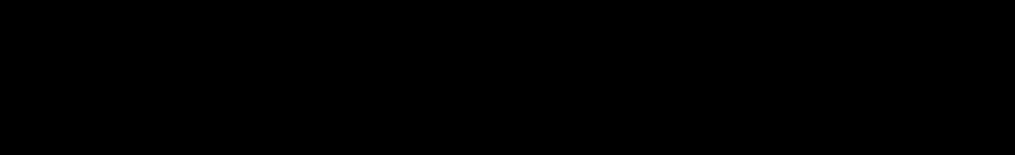

In [16]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year']) #Percent_Cover has 30% of its row NA, so it significantly cuts dataset
df.dropna(inplace=True)


df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4

In [17]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = [col for col in df.columns if col not in num_cols]

target_value_col = "Percent_Bleaching"

In [18]:
# Target value
y = df[target_value_col].to_list()

# Mean prediction
y_median = np.median(y)
y_mean = np.mean(y)

y_pred_median = np.full(len(y), y_median)
y_pred_mean = np.full(len(y), y_mean)

# Metrics Median
mae_median = mean_absolute_error(y, y_pred_median)
rmse_median = root_mean_squared_error(y, y_pred_median)
r2_median = r2_score(y, y_pred_median)

print("Median Baseline Results:")
print(f"MAE: {mae_median:.4f}")
print(f"RMSE: {rmse_median:.4f}")
print(f"R: {r2_median:.4f}")

# Metrics Mean
mae_mean = mean_absolute_error(y, y_pred_mean)
rmse_mean = root_mean_squared_error(y, y_pred_mean)
r2_mean = r2_score(y, y_pred_mean)

print("\nMean Baseline Results:")
print(f"MAE: {mae_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R: {r2_mean:.4f}")



Median Baseline Results:
MAE: 8.0678
RMSE: 19.8756
R: -0.1973

Mean Baseline Results:
MAE: 11.2953
RMSE: 18.1646
R: 0.0000


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Distribution

Histogram shows that target value has a lot of outliers and extremely skewed around 0%, which implies that Percent_Bleaching values has to be scaled to mitigate impact of imbalance distribution and normalized. Nevertheless, The histogram highlights a fundamental difference between population-level and colony-level bleaching observations. Population-level measurements provide a broad, aggregated indication of overall bleaching severity across reef sites, whereas colony-level observations capture finer-scale variability and extreme responses at the individual colony level. Because these two data types represent different ecological scales and statistical distributions, training a single model on both would conflate distinct processes and potentially bias predictions. Therefore, separate models are required to accurately capture bleaching dynamics at each observational scale.

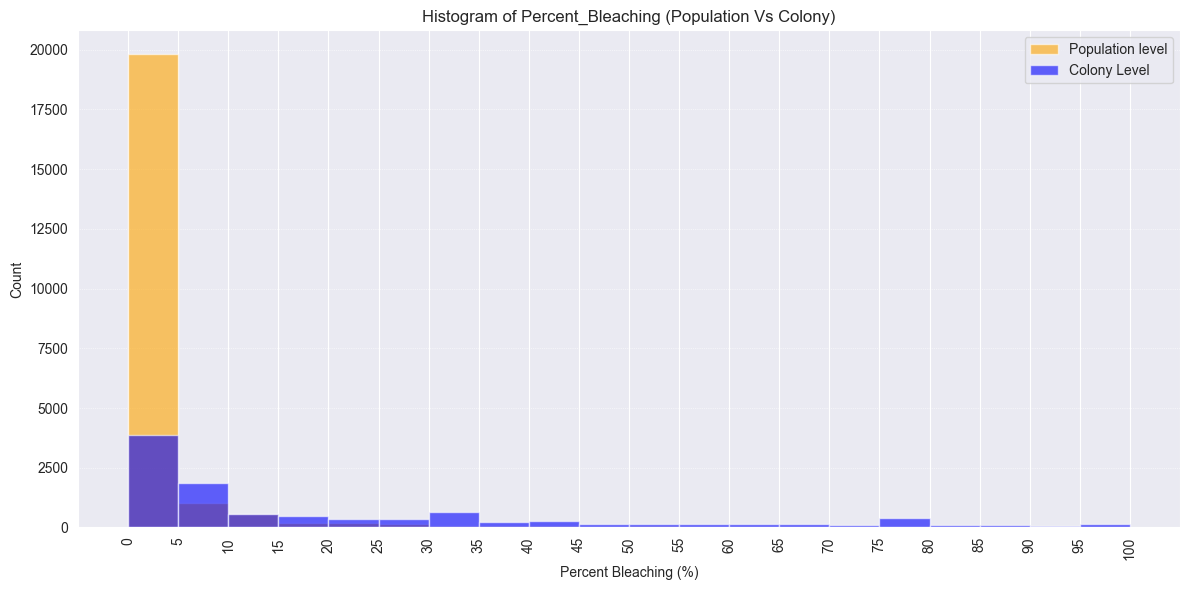

In [19]:
# Create boolean masks to separate samples with and without bleaching

df_population = df[df["Bleaching_Level"] != "Colony"]
df_colony = df[df["Bleaching_Level"] != "Population"]

bins = np.arange(0, 105, 5)  # from 0 to 100 in steps of 0.5

# Generate bin labels (not directly used in plotting)
labels = [f"{b}–{b+5}%" for b in bins[:-1]]

# Plot histogram for no bleaching samples
plt.figure(figsize=(12, 6))
plt.hist(
    df_population[target_value_col],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Population level"
)

# Plot histogram for samples with bleaching
plt.hist(
    df_colony[target_value_col],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Colony Level"
)
plt.xticks(bins)
plt.xlabel("Percent Bleaching (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent_Bleaching (Population Vs Colony)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()



### 4.2 Feature Distribution and Skewness

The majority of numerical features in the dataset exhibit pronounced skewness, with several key variables showing strong right-skew (e.g., Distance_to_Shore, Turbidity, Percent_Bleaching) and others displaying left-skewed distributions (e.g., ClimSST, Temperature_Mean, TSA), indicating non-normal feature distributions and further motivating the use of transformation and non-linear modeling approaches.


In [20]:

def get_skewness(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    skewness_results = {}

    # Iterate through numerical columns
    for col in numeric_cols:
        numeric_data = df[col]

          # Compute skewness only if the column contains data
        if len(numeric_data) > 0:
            skew_val = skew(numeric_data)

            # Store skewness value and categorize its type
            skewness_results[col] = {
                'skewness': skew_val,
                'skew_type': 'Right (Positive)' if skew_val > 0.5 else 'Left (Negative)' if skew_val < -0.5 else 'Approximately Symmetric',

            }

    # Convert and sort results to a DataFrame for easier inspection
    skewness_df = pd.DataFrame(skewness_results).T
    skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)

    print(skewness_df[:-1])
    return skewness_results


skewness_results = get_skewness(df)

                     skewness         skew_type
Distance_to_Shore    9.390477  Right (Positive)
Turbidity            3.848336  Right (Positive)
Percent_Bleaching    2.969849  Right (Positive)
ClimSST             -1.640544   Left (Negative)
Temperature_Mean    -1.320474   Left (Negative)
Depth_m              1.272371  Right (Positive)
TSA                 -1.013456   Left (Negative)
Temperature_Maximum  0.930379  Right (Positive)
Cyclone_Frequency    0.891588  Right (Positive)


### 4.3 Feature Relationships

The Pearson correlation matrix shows generally weak linear relationships among the environmental variables and between predictors and the target variable (Percent_Bleaching). Most correlation coefficients are close to zero, indicating limited linear dependence.

<Axes: >

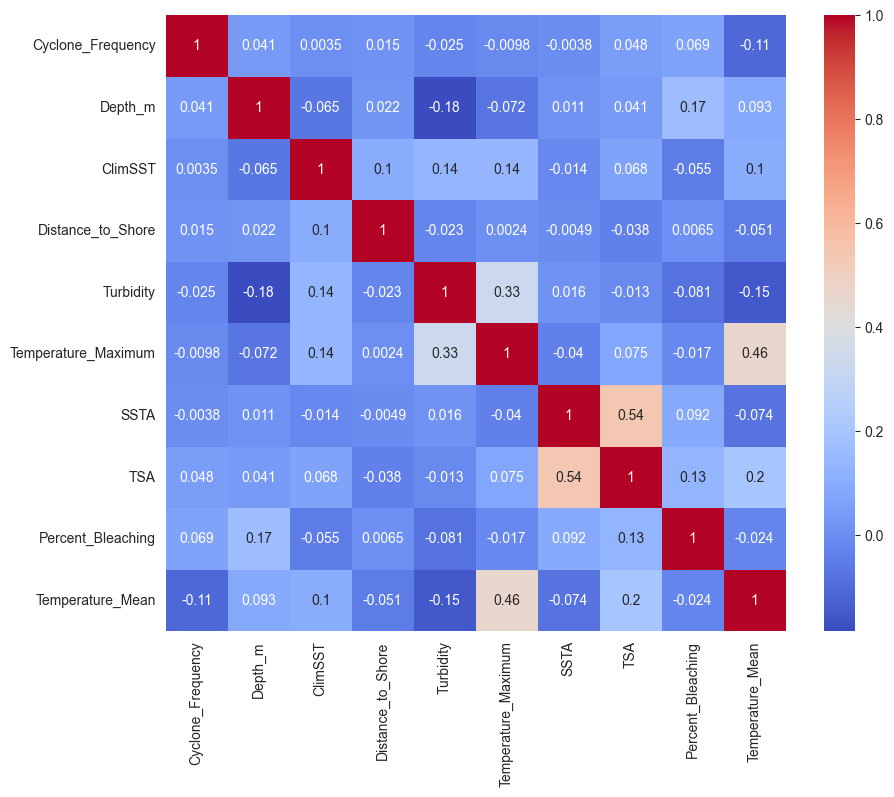

In [21]:

df_numeric = df[num_cols]

pearson_corr_matrix = df_numeric.corr(method="pearson")

features = pearson_corr_matrix.index

# Use Heatmap to visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm")

The Spearman correlation matrix reveals stronger monotonic relationships than those observed with Pearson correlation, indicating that several variables are related in a non-linear but monotonic manner.

<Axes: >

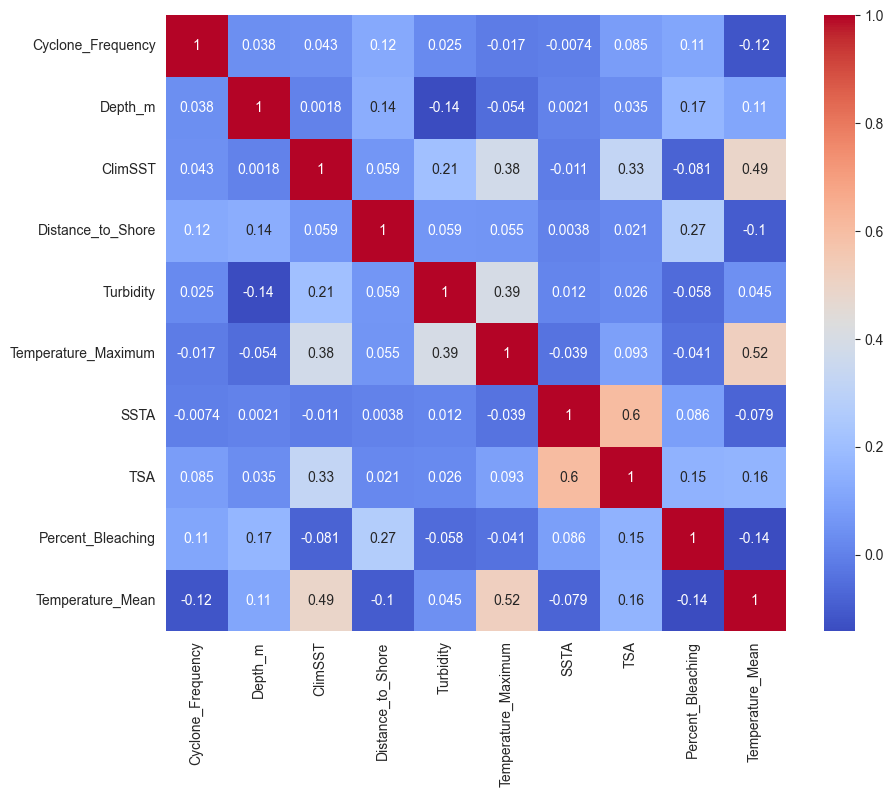

In [22]:
spearman_corr_matrix = df_numeric.corr(method="spearman")
features = spearman_corr_matrix.index

# Use Heatmap to visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm")

The VIF analysis reveals severe multicollinearity among temperature-related variables (Temperature_Mean and ClimSST), confirming strong feature redundancy and motivating the use  non-linear models that are less sensitive to collinearity.

In [23]:
vif_data = pd.DataFrame()

# Add numerical feature names
vif_data["features"] = num_cols

# Compute VIF for each numerical feature by regressing it against all other features
vif_data["vif"] = [
    variance_inflation_factor(df_numeric.values, i)
    for i in range(len(num_cols))
]

vif_data


,features,vif
0,Cyclone_Frequency,51.860955
1,Depth_m,4.060596
2,ClimSST,411.180812
3,Distance_to_Shore,1.109021
4,Turbidity,3.253969
5,Temperature_Maximum,55534.515475
6,SSTA,1.607220
7,TSA,2.062368
8,Percent_Bleaching,1.270236
9,Temperature_Mean,54902.395242


Mutual information regression was used to quantify the non-linear dependency between each numerical feature and the target variable, Percent Bleaching. Unlike correlation-based measures, mutual information captures both linear and non-linear relationships without assuming monotonicity. The results indicate that Distance to Shore, Cyclone Frequency, and temperature-related variables exhibit the strongest non-linear associations with bleaching severity, while Depth shows a comparatively weaker influence. As expected, the target variable itself ranks highest, serving as a validation of the method.


In [24]:
mi_X = df_numeric.drop(target_value_col, axis=1)
mi_X.drop(["Temperature_Maximum", "ClimSST"], axis=1, inplace=True)


## Compute mutual information scores between each numerical feature and the target variable
mi = mutual_info_regression(mi_X, y)
mi_scores = pd.Series(mi, index=mi_X.columns).sort_values(ascending=False)

mi_scores

Distance_to_Shore    0.805935
Cyclone_Frequency    0.734985
Temperature_Mean     0.620852
Turbidity            0.613154
TSA                  0.448136
SSTA                 0.367483
Depth_m              0.183666
dtype: float64

Overall, the dataset exhibits non-linear relationships, significant feature redundancy, skewed feature distributions, and interaction effects, pushing the use of scaled non-linear models and ensemble methods for robust prediction.


## 5. Data Preprocessing

Before selecting feature set it is better to see the effect of categorical data on DecisionTreeRegressor(), since they carry a lot of environmental data

In [25]:
def test_model(model, X_test, y_test, plot_title = ""):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R2 score for {plot_title}: {r2}")
    print(f"MAE score for {plot_title}: {mae}")

    residuals = y_test - y_pred.ravel()

    # Plot residuals vs predicted
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {plot_title}")
    plt.show()


In [26]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df_tmp = pd.read_csv(filename_read)


# Percent_Cover tells how much of a corals were observed. This is irrelevant predictor, so its removed
df_population = df_tmp.drop(columns=['Sample_ID', 'Percent_Cover','Date_Year'])

# Split Population samples from Colony
df_population = df_population[df_population['Bleaching_Level'] != 'Colony']
df_population.drop("Bleaching_Level", axis=1, inplace=True)
df_population.dropna(inplace=True)


df_colony = df_tmp.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year'])
# Split Population samples from Colony
df_colony = df_colony[df_colony['Bleaching_Level'] != 'Population']
df_colony.drop("Bleaching_Level", axis=1, inplace=True)

df_colony.dropna(inplace=True)

df_tmp.info()
df_population.info()
df_colony.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample_ID            41361 non-null  int64  
 1   Cyclone_Frequency    41361 non-null  float64
 2   Depth_m              39562 non-null  float64
 3   ClimSST              41248 non-null  float64
 4   Ocean_Name           41361 non-null  object 
 5   Country_Name         41360 non-null  object 
 6   Distance_to_Shore    41359 non-null  float64
 7   Exposure             41361 non-null  object 
 8   Turbidity            41355 non-null  float64
 9   Date_Year            41361 non-null  int64  
 10  Bleaching_Level      41361 non-null  object 
 11  Temperature_Maximum  41229 non-null  float64
 12  SSTA                 41213 non-null  float64
 13  TSA                  41213 non-null  float64
 14  Percent_Bleaching    34515 non-null  float64
 15  Temperature_Mean     41229 non-null 


### 5.1 Handle N/A

NEED TO BE DONE


### 5.2 Encoding & Transformation and Feature Scaling

To address the skewness observed in the numerical features, skewness-aware transformations were applied to create a normalized version of the dataset. Right-skewed variables were transformed using the Box–Cox transformation after ensuring strictly positive values with a small shift for zero-values, while left-skewed variables were normalized using the Yeo–Johnson power transformation, which supports negative values. All transformations were applied to a separate normalized dataset to preserve the original data, improving distributional symmetry and supporting more stable and effective training of scale-sensitive models.


In [27]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import numpy as np

def normalize_df(df, skewness_results):

    df_normalized = df.copy()

    right_skewed = [
        col for col, v in skewness_results.items()
        if v["skewness"] > 0.5 and col in df_normalized.columns
    ]

    left_skewed = [
        col for col, v in skewness_results.items()
        if v["skewness"] < -0.5 and col in df_normalized.columns
    ]

    print("Left-skewed:", left_skewed)
    print("Right-skewed:", right_skewed)

    for col in right_skewed:
        x = df_normalized[col]

        # Skip if constant or all NaN
        if x.nunique(dropna=True) <= 1:
            continue

        if (x <= 0).any():
            pt = PowerTransformer(method="yeo-johnson")
            df_normalized[[col]] = pt.fit_transform(df_normalized[[col]])
            continue

        try:
            non_null = x.notna()
            df_normalized.loc[non_null, col], _ = boxcox(x[non_null])
        except Exception:
            # Fallback safety
            pt = PowerTransformer(method="yeo-johnson")
            df_normalized[[col]] = pt.fit_transform(df_normalized[[col]])

    for col in left_skewed:
        if df_normalized[col].nunique(dropna=True) <= 1:
            continue

        pt = PowerTransformer(method="yeo-johnson")
        df_normalized[[col]] = pt.fit_transform(df_normalized[[col]])

    return df_normalized


In [28]:
# Compute skewness for numerical features in both dataset variants
skewness_results_population = get_skewness(df_population)
skewness_results_colony = get_skewness(df_colony)

# Apply skewness-based normalization to each dataset
df_normalized_population = normalize_df(df_population, skewness_results_population)
df_normalized_colony = normalize_df(df_colony, skewness_results_colony)

                     skewness         skew_type
Distance_to_Shore    8.244481  Right (Positive)
Percent_Bleaching    6.034016  Right (Positive)
Turbidity            3.645118  Right (Positive)
ClimSST             -1.779477   Left (Negative)
Temperature_Mean     -1.13644   Left (Negative)
Cyclone_Frequency    1.024783  Right (Positive)
TSA                 -0.994456   Left (Negative)
Temperature_Maximum  0.918675  Right (Positive)
Depth_m              0.518151  Right (Positive)
                      skewness                skew_type
Distance_to_Shore    13.845577         Right (Positive)
Turbidity             4.147386         Right (Positive)
Temperature_Mean     -2.893948          Left (Negative)
Percent_Bleaching     1.453616         Right (Positive)
ClimSST               -1.37953          Left (Negative)
Depth_m               1.203799         Right (Positive)
TSA                  -1.128713          Left (Negative)
Temperature_Maximum   0.549186         Right (Positive)
SSTA            

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Left-skewed: ['ClimSST', 'TSA', 'Temperature_Mean']
Right-skewed: ['Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum', 'Percent_Bleaching']


C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Categorical and numerical features were processed separately: categorical variables were encoded using one-hot encoding to convert them into a numerical representation, while numerical features were standardized to zero mean and unit variance. Scaling was applied even after normalization to ensure comparable feature magnitudes, which is particularly important for distance-based and gradient-based models. Finally, the processed numerical and categorical features were combined into a single feature matrix used for model training and evaluation.

In [29]:
def get_preprocessed_split_data(df):
    # Determine usable columns directly from the dataset

    # Split first (no leakage)
    X = df.drop(columns=[target_value_col])
    y = df[target_value_col]


    num_used = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_used = [col for col in X.columns if col not in num_used]


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


# We one_hot_encode the categorical features
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


    X_train_cat = ohe.fit_transform(X_train[cat_used])
    X_test_cat  = ohe.transform(X_test[cat_used])
    X_cat = ohe.transform(X[cat_used])

    ohe_feature_names = ohe.get_feature_names_out(cat_used)

    # We scale the numeric features
    scaler = StandardScaler()

    # Even after normalization its still crucial to scale-up data
    X_train_num = scaler.fit_transform(X_train[num_used])
    X_test_num  = scaler.transform(X_test[num_used])
    X_num = scaler.transform(X[num_used])


    # Combine the categorical and numerical features
    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed  = np.hstack([X_test_num, X_test_cat])
    X_processed = np.hstack([X_num, X_cat])

    # Store final processed feature names in correct order
    processed_feature_names = np.concatenate([num_used, ohe_feature_names])

    # Return processed data and metadata as dictionary
    return {
    "X_processed": X_processed,
    "y": y,
    "X_train": X_train_processed,
    "X_test": X_test_processed,
    "y_train": y_train,
    "y_test": y_test,
    "feature_names": processed_feature_names
}

In [30]:
data_population = get_preprocessed_split_data(df_normalized_population)
data_colony = get_preprocessed_split_data(df_normalized_colony)


## 6. Support Vector Machines (SVM)

### 6.1 Motivation for SVM

Support Vector Machines (SVM) were initially selected due to their conceptual simplicity, strong theoretical grounding, and flexibility in modelling both linear and non-linear relationships through a variety of kernel functions. This versatility makes SVMs powerful in many structured prediction tasks.

### 6.2 Kernel Experiments

#### 6.2.1 RBF Kernel




In [31]:
model_svr_population = SVR(kernel="rbf", shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="rbf", shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR()

R2 score for SVM (kernel = rbf) Population samples: 0.13384300202128985
MAE score for SVM (kernel = rbf) Population samples: 0.5780571287890583


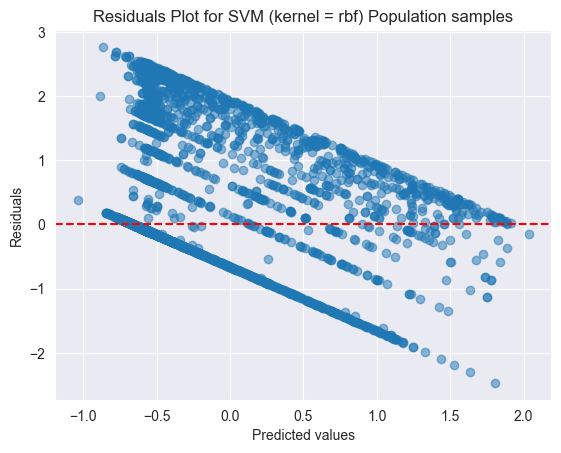

In [32]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = rbf) Population samples")

R2 score for SVM (kernel = rbf) Colony samples: 0.5285060377628872
MAE score for SVM (kernel = rbf) Colony samples: 0.5150337509143165


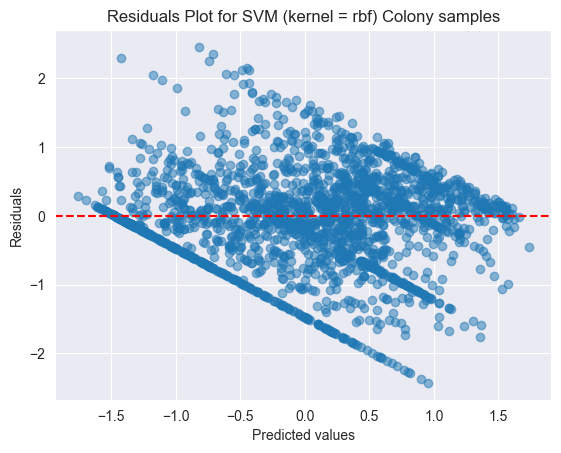

In [33]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SVM (kernel = rbf) Colony samples")

#### 6.2.2 Polynomial Kernel (degree 2)



In [34]:
model_svr_population = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR(degree=2, kernel='poly')

R2 score for SVM (kernel = poly, degree 2) Population samples: 0.048455644126328745
MAE score for SVM (kernel = poly, degree 2) Population samples: 0.6110398282709496


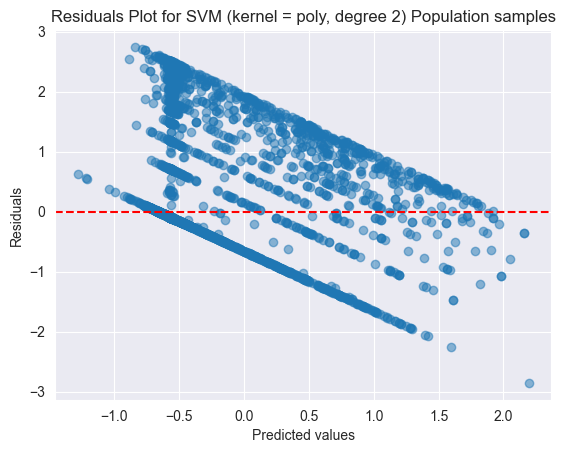

In [35]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = poly, degree 2) Population samples")

R2 score for SMV (kernel = poly, degree 2) Colony samples: 0.44878324717385776
MAE score for SMV (kernel = poly, degree 2) Colony samples: 0.5718678743434942


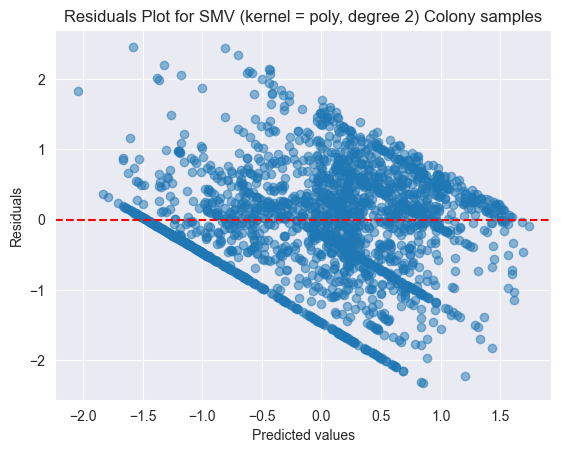

In [36]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SMV (kernel = poly, degree 2) Colony samples")

#### 6.2.3 Polynomial Kernel (degree 3)

In [37]:
model_svr_population = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)
model_svr_colony = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)

model_svr_population.fit(data_population["X_train"], data_population["y_train"])
model_svr_colony.fit(data_colony["X_train"], data_colony["y_train"])

SVR(kernel='poly')

R2 score for SVM (kernel = poly, degree = 3) Population samples: 0.11684206756116466
MAE score for SVM (kernel = poly, degree = 3) Population samples: 0.5882721392653859


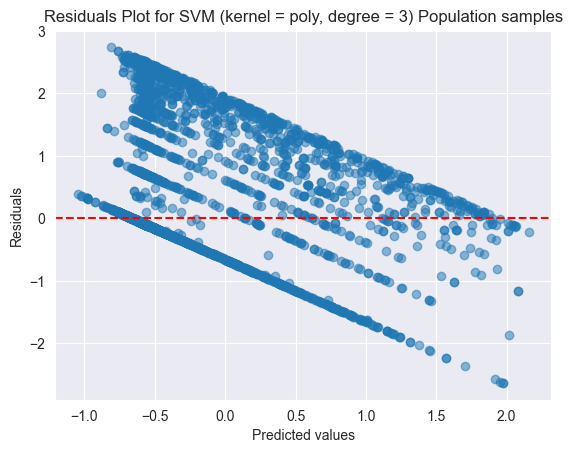

In [38]:
test_model(model_svr_population, data_population["X_test"], data_population["y_test"], "SVM (kernel = poly, degree = 3) Population samples")

R2 score for SVM (kernel = poly, degree = 3) Colony samples: 0.49653499098938725
MAE score for SVM (kernel = poly, degree = 3) Colony samples: 0.535431043339265


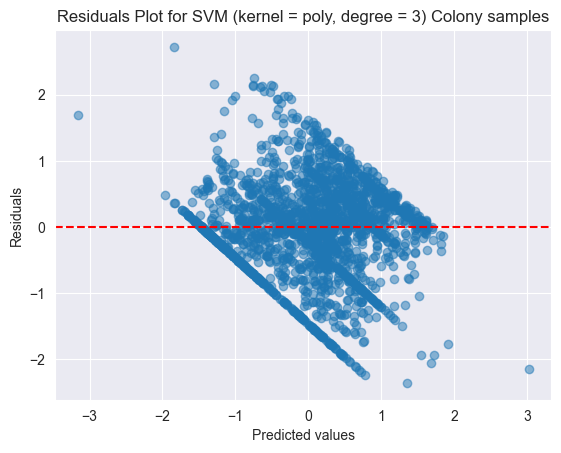

In [39]:
test_model(model_svr_colony, data_colony["X_test"], data_colony["y_test"], "SVM (kernel = poly, degree = 3) Colony samples")

### 6.3 SVM Results Comparison

 SVMs showed persistent scalability limitations when applied to our dataset. Training non-linear kernels was computationally expensive, making large-scale tuning impractical.

Additionally, SVMs are sensitive to multicollinearity, which can distort the margin geometry and lead to unstable predictions. For this reason, only some experiments were selected for SVMs.




## 7. Ensemble Tree Models

A feature importance analysis was conducted using a Decision Tree Regressor to quantify the contribution of each predictor to the model’s performance. Importance scores were aggregated at the base-feature level to account for one-hot encoded categorical variables, and features exceeding a predefined importance threshold were selected as the most influential predictors


In [40]:
def get_base_feature(feature_name):
    for col in list(num_cols) + list(cat_cols):
        # Handles one-hot encoded names like Country_Name_Australia
        if feature_name == col or feature_name.startswith(col + "_"):
            return col
    return feature_name  # fallback


def tree_feature_importance(X, y, processed_feature_names, threshold=0.01, model=None):

    # If no tree based model is provided, train a default Decision Tree regressor
    if model is None:
        model = DecisionTreeRegressor()
        model.fit(X, y)


    importance = model.feature_importances_

    # Create a DataFrame pairing each processed feature with its importance score and sort by
    importance_df = pd.DataFrame({
        "feature": processed_feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)

    # Map each processed (possibly one-hot encoded) feature back to its base feature
    importance_df["base_feature"] = importance_df["feature"].apply(get_base_feature)

    # Aggregate importance scores by base feature
    # This sums contributions from all one-hot encoded levels of categorical variables
    grouped_importance = (
        importance_df
        .groupby("base_feature")["importance"]
        .sum()
        .sort_values(ascending=False)
    )

    # Select base features whose aggregated importance exceeds the given threshold
    selected_features_tree = [
        f for f, s in zip(grouped_importance.index, grouped_importance.values)
        if s > threshold
    ]

    # Print selected features and full aggregated importance table for inspection
    print(f"Selected features for trees: {selected_features_tree}")
    print(grouped_importance)

    # Append the target variable so the returned dataset remains model-ready
    selected_features_tree.append(target_value_col)

    return selected_features_tree


In [41]:
selected_features_tree_population = tree_feature_importance(data_population["X_processed"], data_population["y"], data_population["feature_names"])
selected_features_tree_colony = tree_feature_importance(data_colony["X_processed"], data_colony["y"], data_colony["feature_names"])

Selected features for trees: ['TSA', 'SSTA', 'ClimSST', 'Distance_to_Shore', 'Depth_m', 'Country_Name', 'Temperature_Mean', 'Cyclone_Frequency', 'Turbidity', 'Realm_Name', 'Exposure']
base_feature
TSA                    0.155725
SSTA                   0.120734
ClimSST                0.118728
Distance_to_Shore      0.111751
Depth_m                0.107566
Country_Name           0.106869
Temperature_Mean       0.082808
Cyclone_Frequency      0.078842
Turbidity              0.063817
Realm_Name             0.035988
Exposure               0.016248
Ocean_Name             0.000924
Temperature_Maximum    0.000000
Name: importance, dtype: float64
Selected features for trees: ['TSA', 'Country_Name', 'Temperature_Mean', 'Cyclone_Frequency', 'ClimSST', 'Distance_to_Shore', 'Depth_m', 'SSTA', 'Turbidity', 'Ocean_Name', 'Exposure']
base_feature
TSA                    0.154882
Country_Name           0.148901
Temperature_Mean       0.125841
Cyclone_Frequency      0.105101
ClimSST                0.0969

### 7.1 Model Selection

Random Forest and XGBoost were selected as advanced ensemble learning methods to evaluate their capacity to model complex, non-linear relationships within the dataset. Both methods provide robust predictive performance, strong generalization, and built-in mechanisms to handle feature interactions, making them well-suited for heterogeneous environmental datasets. Their ability to capture non-linear patterns without extensive feature engineering motivated their use after simpler baseline models demonstrated limited effectiveness.




### 7.2 Initial Ensemble Training

In [42]:
tree_data_population = get_preprocessed_split_data(df_normalized_population[selected_features_tree_population])
tree_data_colony = get_preprocessed_split_data(df_normalized_colony[selected_features_tree_colony])

In [43]:
xgb_model_population = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)
xgb_model_colony = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)


xgb_model_population.fit(tree_data_population["X_train"], tree_data_population["y_train"])
xgb_model_colony.fit(tree_data_colony["X_train"], tree_data_colony["y_train"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

R2 score for XGBoost Population samples: 0.8063554846821561
MAE score for XGBoost Population samples: 0.15429646867694277


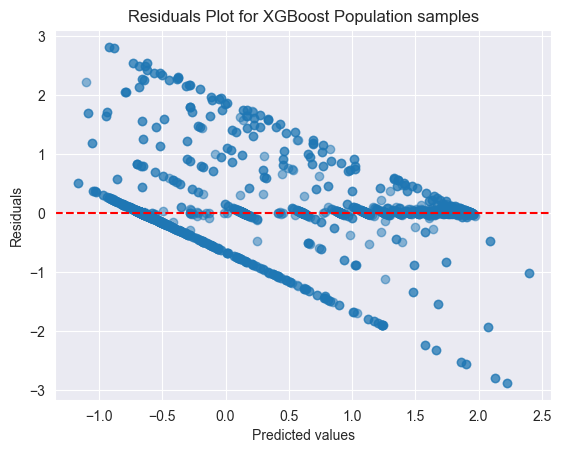

In [44]:
test_model(xgb_model_population, tree_data_population["X_test"], tree_data_population["y_test"], "XGBoost Population samples")

R2 score for XGBoost Colony samples: 0.6585370147278293
MAE score for XGBoost Colony samples: 0.39282213434903346


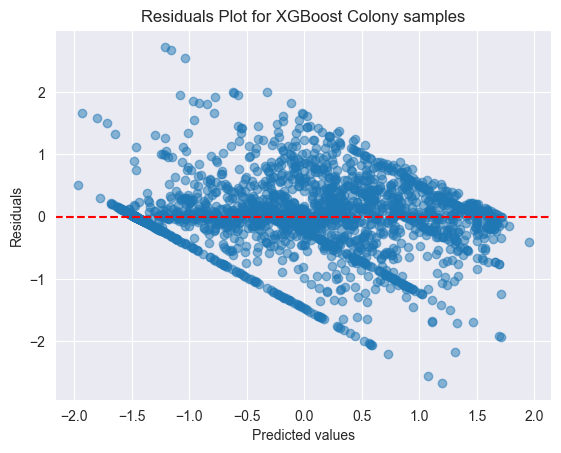

In [45]:
test_model(xgb_model_colony, tree_data_colony["X_test"], tree_data_colony["y_test"], "XGBoost Colony samples")

In [46]:
rf_model_population = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

rf_model_colony = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

rf_model_population.fit(tree_data_population["X_train"], tree_data_population["y_train"])
rf_model_colony.fit(tree_data_colony["X_train"], tree_data_colony["y_train"])

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

R2 score for Randon Forest Population samples: 0.8323408580671886
MAE score for Randon Forest Population samples: 0.13896508449506514


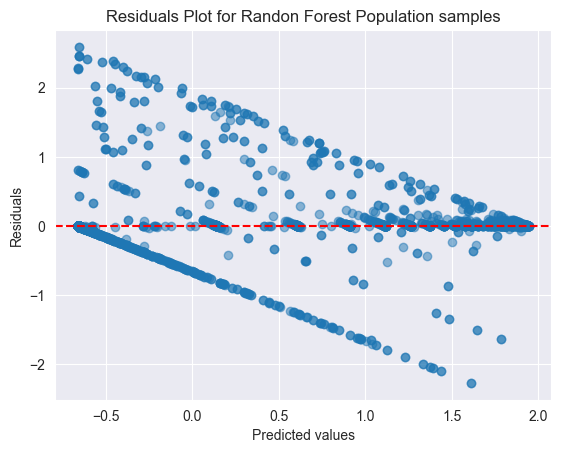

In [47]:
test_model(rf_model_population, tree_data_population["X_test"], tree_data_population["y_test"], "Randon Forest Population samples")

R2 score for Randon Forest Population samples: 0.696622002193686
MAE score for Randon Forest Population samples: 0.3589640132680947


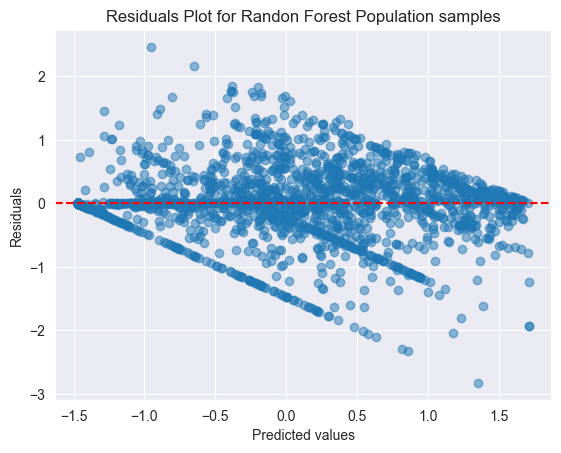

In [48]:
test_model(rf_model_colony, tree_data_colony["X_test"], tree_data_colony["y_test"], "Randon Forest Population samples")

### 7.4 Hyperparameter Refinement

Further feature refinement was not performed, as the selected feature set already demonstrated strong performance.

In [49]:
refined_features_tree_population = tree_feature_importance(tree_data_population["X_processed"], tree_data_population["y"], tree_data_population["feature_names"], threshold=0.02, model=rf_model_population)

refined_features_tree_colony = tree_feature_importance(tree_data_colony["X_processed"], tree_data_colony["y"], tree_data_colony["feature_names"], threshold=0.02, model=rf_model_colony)

refined_tree_data_population = get_preprocessed_split_data(df_normalized_population[refined_features_tree_population])
refined_tree_data_colony = get_preprocessed_split_data(df_normalized_colony[refined_features_tree_colony])

Selected features for trees: ['TSA', 'SSTA', 'ClimSST', 'Depth_m', 'Distance_to_Shore', 'Country_Name', 'Temperature_Mean', 'Cyclone_Frequency', 'Turbidity', 'Realm_Name']
base_feature
TSA                  0.143872
SSTA                 0.128046
ClimSST              0.118745
Depth_m              0.110595
Distance_to_Shore    0.110343
Country_Name         0.101216
Temperature_Mean     0.091969
Cyclone_Frequency    0.077120
Turbidity            0.071362
Realm_Name           0.029281
Exposure             0.017452
Name: importance, dtype: float64
Selected features for trees: ['TSA', 'Country_Name', 'Temperature_Mean', 'ClimSST', 'Depth_m', 'Cyclone_Frequency', 'Distance_to_Shore', 'SSTA', 'Turbidity', 'Ocean_Name']
base_feature
TSA                  0.157592
Country_Name         0.135896
Temperature_Mean     0.134179
ClimSST              0.099562
Depth_m              0.097155
Cyclone_Frequency    0.086445
Distance_to_Shore    0.085406
SSTA                 0.081603
Turbidity            0.0672

In [50]:
refined_xgb_model_population = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0,  # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)
refined_xgb_model_colony = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0,  # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)

refined_xgb_model_population.fit(refined_tree_data_population["X_train"], refined_tree_data_population["y_train"])
refined_xgb_model_colony.fit(refined_tree_data_colony["X_train"], refined_tree_data_colony["y_train"])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

R2 score for Refined XGBoost Population samples: 0.8023479072781903
MAE score for Refined XGBoost Population samples: 0.15806360112599036


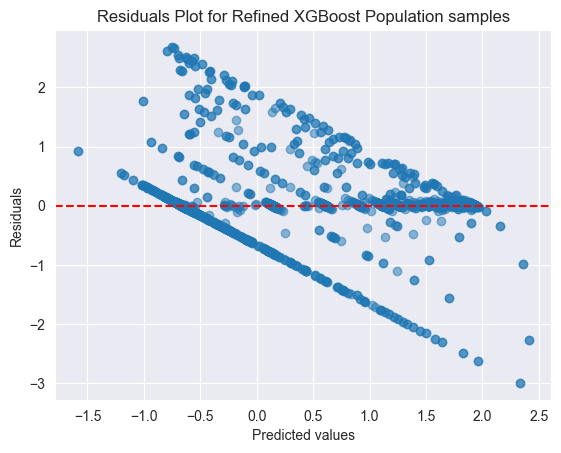

In [51]:
test_model(refined_xgb_model_population, refined_tree_data_population["X_test"], refined_tree_data_population["y_test"], "Refined XGBoost Population samples")

R2 score for Refined XGBoost Colony samples: 0.65606814447945
MAE score for Refined XGBoost Colony samples: 0.39286295849303854


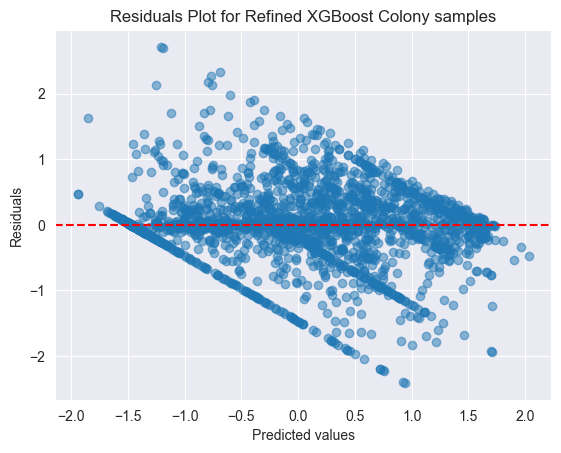

In [52]:
test_model(refined_xgb_model_colony, refined_tree_data_colony["X_test"], refined_tree_data_colony["y_test"], "Refined XGBoost Colony samples")

In [53]:
refined_rf_model_population = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

refined_rf_model_colony = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    criterion="friedman_mse",
    max_features=0.5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.,
    bootstrap=False,
    random_state=42,
    n_jobs=-1)

refined_rf_model_population.fit(refined_tree_data_population["X_train"], refined_tree_data_population["y_train"])
refined_rf_model_colony.fit(refined_tree_data_colony["X_train"], refined_tree_data_colony["y_train"])

RandomForestRegressor(bootstrap=False, criterion='friedman_mse', max_depth=30,
                      max_features=0.5, n_estimators=600, n_jobs=-1,
                      random_state=42)

R2 score for Refined Randon Forest Population samples: 0.8334254312549976
MAE score for Refined Randon Forest Population samples: 0.13752332480881344


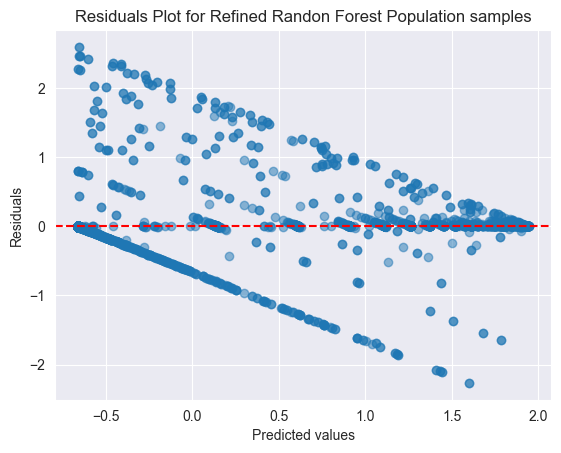

In [54]:
test_model(refined_rf_model_population, refined_tree_data_population["X_test"], refined_tree_data_population["y_test"], "Refined Randon Forest Population samples")

R2 score for Refined Randon Forest Population samples: 0.6976120354206017
MAE score for Refined Randon Forest Population samples: 0.35874180986385124


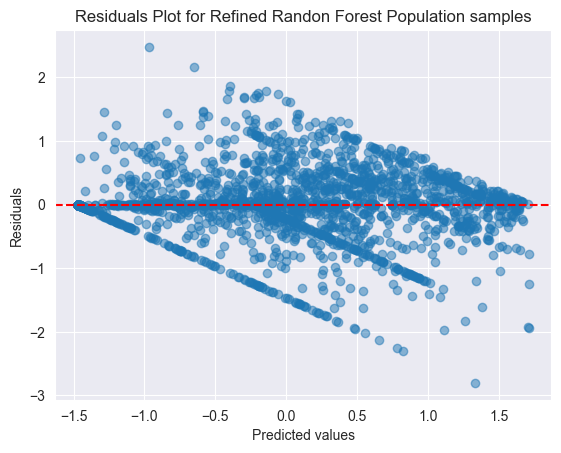

In [55]:
test_model(refined_rf_model_colony, refined_tree_data_colony["X_test"], refined_tree_data_colony["y_test"], "Refined Randon Forest Population samples")

### 7.5 Ensemble Results

Random Forest demonstrated the most robust performance, achieving the lowest MAE and stable R2, especially in the presence of numerous high-bleaching outliers. Its architecture of aggregated decision trees made it less sensitive to noise and better able to approximate the real distribution of extreme bleaching values.
	XGBoost delivered similarly strong results and showed superior performance within the main cluster of bleaching values. It benefited more from feature engineering than Random Forest, improving significantly after removing weak or correlated predictors. However, XGBoost tended to make fewer but larger errors, making it slightly less reliable in the outlier-heavy tail of the target distribution.


## 8. Deep Neural Networks (DNN)

### 8.1 Motivation for Deep Neural Networks (DNN)

* **Handle non-linear relationships:** DNNs can model complex, non-linear dependencies between environmental and geographic variables.
* **Leverage high-dimensional interactions:** While DNNs can learn interactions automatically, explicit feature engineering (threshold-based, interaction, and group-wise features) improves their ability to capture key ecological patterns.

### 8.2 Feature engineering for DNN

These engineered features capture the joint effect of two variables on coral bleaching that might not be captured.

In [56]:
dnn_df_population = df_population.copy()
dnn_df_colony = df_colony.copy()


dnn_df_colony.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 35044
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    10295 non-null  float64
 1   Depth_m              10295 non-null  float64
 2   ClimSST              10295 non-null  float64
 3   Ocean_Name           10295 non-null  object 
 4   Country_Name         10295 non-null  object 
 5   Distance_to_Shore    10295 non-null  float64
 6   Exposure             10295 non-null  object 
 7   Turbidity            10295 non-null  float64
 8   Temperature_Maximum  10295 non-null  float64
 9   SSTA                 10295 non-null  float64
 10  TSA                  10295 non-null  float64
 11  Percent_Bleaching    10295 non-null  float64
 12  Temperature_Mean     10295 non-null  float64
 13  Realm_Name           10295 non-null  object 
dtypes: float64(10), object(4)
memory usage: 1.2+ MB


**Interaction Feature Engineering**

To capture potential nonlinear relationships between predictors, pairwise interaction features were generated by multiplying selected combinations of variables. Interaction terms were created only when both constituent features were present in the dataset, ensuring robustness across different data subsets. This approach enables the model to account for joint effects that may not be captured by individual features alone.

In [57]:
def create_interaction_features(df, interactions):

    df_copy = df.copy()

    # Loop over each specified pair of features
    for a, b in interactions:

        # Ensure both features exist in the DataFrame
        if a in df_copy.columns and b in df_copy.columns:
            # Create an interaction feature by multiplying the two columns
            df_copy[f"{a}_x_{b}"] = df_copy[a] * df_copy[b]

    # Return the DataFrame with added interaction features
    return df_copy

In [58]:
interactions = [
    # Thermal stress vs physical conditions
    ("TSA", "Depth_m"),             # Shallow reefs may bleach more under thermal stress
    ("TSA", "Distance_to_Shore"),   # Coastal reefs may respond differently to thermal anomalies

    # Water clarity & stress
    ("Turbidity", "Temperature_Mean"), # Murky water + high temps reduce photosynthesis
    ("Turbidity", "Distance_to_Shore"),# Turbidity often higher nearshore


    # Cyclones / physical disturbance
    ("Cyclone_Frequency", "Depth_m"),           # Shallow reefs more impacted by storms
    ("Cyclone_Frequency", "Temperature_Mean"),  # Heat stress + cyclone damage interaction
    ("Cyclone_Frequency", "Distance_to_Shore"), # Coastal and open ocean effects

    # Geographical conditions
    ("Depth_m", "Distance_to_Shore"),   # Coastal shallow reefs behave differently
]

dnn_df_interaction_population = create_interaction_features(dnn_df_population, interactions)
dnn_df_interaction_colony = create_interaction_features(dnn_df_colony, interactions)


**Group-Based Feature Normalization and Category Consolidation**

Group-based normalization was applied to selected numerical variables to account for systematic differences across categorical groupings. For each specified feature, values were standardized within groups defined by a reference categorical variable using z-score normalization, computed relative to the group mean and standard deviation. To prevent numerical instability, a small constant was added to the denominator.

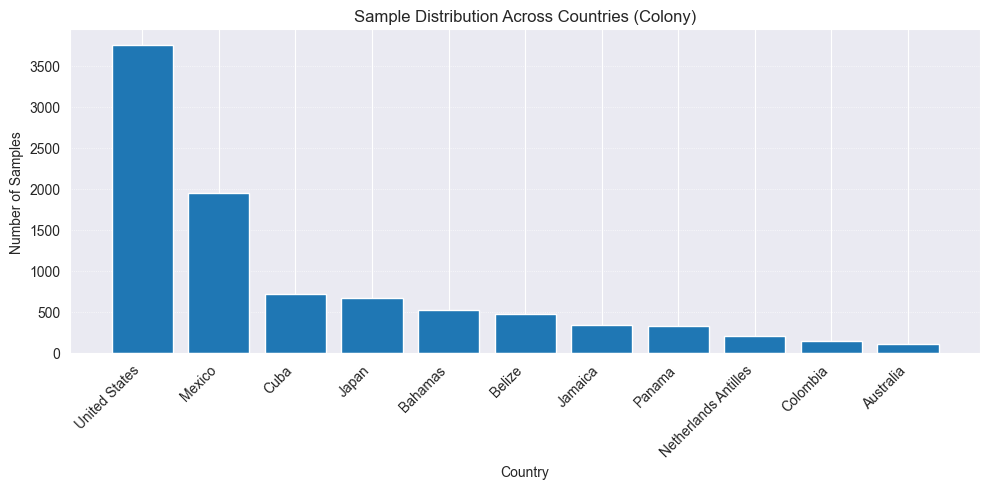

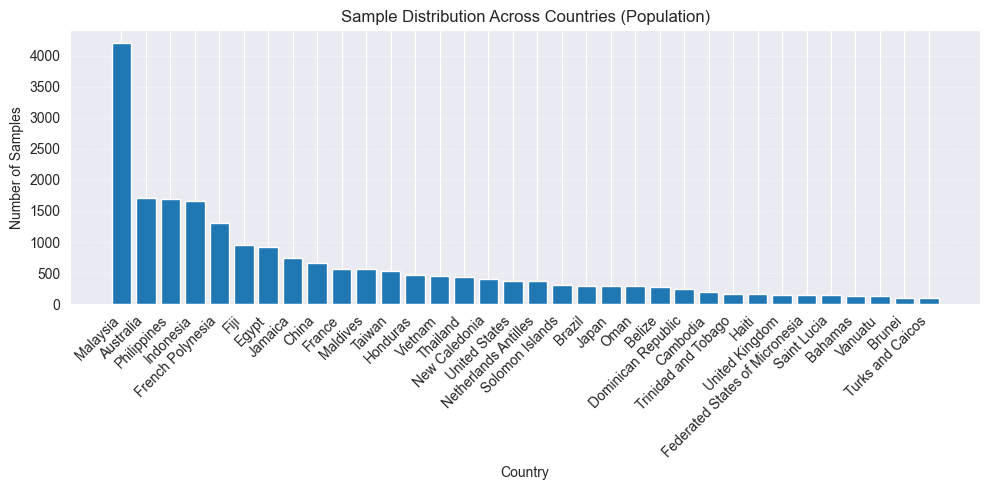

In [59]:
def plot_country_distribution(df, title, min_n=100):
    country_count = df["Country_Name"].value_counts()
    country_count = country_count[country_count >= min_n]

    plt.figure(figsize=(10, 5))
    plt.bar(country_count.index, country_count.values)
    plt.xlabel("Country")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle=":", linewidth=0.5)
    plt.tight_layout()
    plt.show()


plot_country_distribution(dnn_df_colony, "Sample Distribution Across Countries (Colony)")
plot_country_distribution(dnn_df_population, "Sample Distribution Across Countries (Population)")


In [60]:
def group_normalize(df, value_cols, group_col):

    if target_value_col in value_cols:
        value_cols.remove(target_value_col)


    df_copy = df.copy()

    # Apply group-wise z-score normalization for each specified numerical column
    for col in value_cols:
        df_copy[f"{col}_grp_z"] = (
            df_copy[col] -
            df_copy.groupby(group_col)[col].transform("mean")   # Subtract group mean
        ) / (
            df_copy.groupby(group_col)[col].transform("std") + 1e-6 # Divide by group std
        )

    return df_copy


In [61]:
def add_valid_groups(df, min_n=100):
    # Create a copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Identify countries with at least min_n observations
    valid_countries = (
        df_copy["Country_Name"]
        .value_counts()             # Count observations per country
        .loc[lambda x: x >= min_n]  # Keep only sufficiently frequent countries
        .index
    )

    # Assign infrequent countries to a common 'Other' category
    df_copy["Country_group"] = df_copy["Country_Name"].where(
        df_copy["Country_Name"].isin(valid_countries),
        "Other"
    )

    # Identify exposure categories with at least min_n observations
    valid_exposure = (
        df_copy["Exposure"]
        .value_counts()
        .loc[lambda x: x >= min_n]  # Keep only sufficiently frequent categories
        .index
    )

    # Assign infrequent exposure categories to a common 'Other' category
    df_copy["Exposure_group"] = df_copy["Exposure"].where(
        df_copy["Exposure"].isin(valid_exposure),
        "Other"
    )

    # Return the DataFrame with consolidated categorical groupings
    return df_copy


In [62]:
# # Select numeric columns (exclude target)

dnn_df_groups_population = add_valid_groups(dnn_df_interaction_population, min_n=50)
dnn_df_groups_colony = add_valid_groups(dnn_df_interaction_colony)

dnn_num_cols_population = (
    dnn_df_groups_population
    .select_dtypes(include=[np.number])
    .columns
    .drop("Percent_Bleaching")
    .tolist()
)

dnn_num_cols_colony = (
    dnn_df_groups_colony
    .select_dtypes(include=[np.number])
    .columns
    .drop("Percent_Bleaching")
    .tolist()
)

dnn_df_groups_population = group_normalize(dnn_df_groups_population, value_cols=dnn_num_cols_population, group_col="Country_group")
dnn_df_groups_population = group_normalize(dnn_df_groups_population, value_cols=dnn_num_cols_population, group_col="Exposure_group")


dnn_df_groups_colony = group_normalize(dnn_df_groups_colony, value_cols=dnn_num_cols_colony, group_col="Country_group")
dnn_df_groups_colony = group_normalize(dnn_df_groups_colony, value_cols=dnn_num_cols_colony, group_col="Exposure_group")


dnn_df_groups_colony.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 35044
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Cyclone_Frequency                            10295 non-null  float64
 1   Depth_m                                      10295 non-null  float64
 2   ClimSST                                      10295 non-null  float64
 3   Ocean_Name                                   10295 non-null  object 
 4   Country_Name                                 10295 non-null  object 
 5   Distance_to_Shore                            10295 non-null  float64
 6   Exposure                                     10295 non-null  object 
 7   Turbidity                                    10295 non-null  float64
 8   Temperature_Maximum                          10295 non-null  float64
 9   SSTA                                         10295 non-null  float64
 10  TSA

In [63]:
# Compute skewness
dnn_skewness_population = get_skewness(dnn_df_groups_population)
dnn_skewness_colony = get_skewness(dnn_df_groups_colony)

# Normalize data
dnn_df_normalized_population = normalize_df(
    dnn_df_groups_population, dnn_skewness_population
)

dnn_df_normalized_colony = normalize_df(
    dnn_df_groups_colony, dnn_skewness_colony
)

dnn_df_normalized_colony.info()

                                             skewness                skew_type
Cyclone_Frequency_x_Distance_to_Shore         9.71311         Right (Positive)
TSA_x_Distance_to_Shore                     -9.577349          Left (Negative)
TSA_x_Distance_to_Shore_grp_z               -8.771947          Left (Negative)
Depth_m_x_Distance_to_Shore                  8.518925         Right (Positive)
Cyclone_Frequency_x_Distance_to_Shore_grp_z  8.450558         Right (Positive)
Distance_to_Shore                            8.244481         Right (Positive)
Distance_to_Shore_grp_z                       8.09179         Right (Positive)
Depth_m_x_Distance_to_Shore_grp_z             6.74042         Right (Positive)
Turbidity_x_Distance_to_Shore                6.102161         Right (Positive)
Percent_Bleaching                            6.034016         Right (Positive)
Turbidity_x_Distance_to_Shore_grp_z          5.615773         Right (Positive)
Turbidity_x_Temperature_Mean                 3.65283

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Left-skewed: ['ClimSST', 'TSA', 'Temperature_Mean', 'TSA_x_Depth_m', 'TSA_x_Distance_to_Shore', 'ClimSST_grp_z', 'TSA_grp_z', 'Temperature_Mean_grp_z', 'TSA_x_Depth_m_grp_z', 'TSA_x_Distance_to_Shore_grp_z']
Right-skewed: ['Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum', 'Percent_Bleaching', 'Turbidity_x_Temperature_Mean', 'Turbidity_x_Distance_to_Shore', 'Cyclone_Frequency_x_Depth_m', 'Cyclone_Frequency_x_Distance_to_Shore', 'Depth_m_x_Distance_to_Shore', 'Cyclone_Frequency_grp_z', 'Depth_m_grp_z', 'Distance_to_Shore_grp_z', 'Turbidity_grp_z', 'Temperature_Maximum_grp_z', 'Turbidity_x_Temperature_Mean_grp_z', 'Turbidity_x_Distance_to_Shore_grp_z', 'Cyclone_Frequency_x_Depth_m_grp_z', 'Cyclone_Frequency_x_Temperature_Mean_grp_z', 'Cyclone_Frequency_x_Distance_to_Shore_grp_z', 'Depth_m_x_Distance_to_Shore_grp_z']
<class 'pandas.core.frame.DataFrame'>
Index: 10295 entries, 0 to 35044
Data columns (total 41 columns):
 #   Column                                       Non

C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [64]:

dnn_data_population = get_preprocessed_split_data(dnn_df_normalized_population)
dnn_data_colony = get_preprocessed_split_data(dnn_df_normalized_colony)

### 8.3 Architecture Design

The neural network uses two fully connected hidden layers with ReLU activation to model nonlinear relationships while maintaining moderate complexity. The network architecture follows a common rule-of-thumb in which the number of hidden units is set to approximately two-thirds of the input dimensionality, providing sufficient model capacity. To balance expressiveness and overfitting,  dropouts were applied for regularization. A single linear output neuron is used for continuous target prediction.

In [65]:
def get_dnn(X):

    nodes_number = int((X.shape[1] + 1) * 2/3)

    model = Sequential()
    model.add(Input(shape = (X.shape[1],)))
    model.add(Dense(nodes_number, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(nodes_number, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    return model


In [66]:
model_dnn_population = get_dnn(dnn_data_population["X_train"])

model_dnn_colony = get_dnn(dnn_data_colony["X_train"])

model_dnn_population.summary()
model_dnn_colony.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 116)            │        20,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 116)            │        13,572 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           117 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,873 (132.32 KB)

 Trainable params: 33,873 (132.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 81)             │         9,882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 81)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 81)             │         6,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 81)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,606 (64.87 KB)

 Trainable params: 16,606 (64.87 KB)

 Non-trainable params: 0 (0.00 B)

### 8.4 Training & Optimization

  Both neural network models were trained using the mean squared error (MSE) loss function, appropriate for continuous regression tasks, and optimized with the Adam optimizer due to its adaptive learning rate and stable convergence properties. Model performance was monitored using mean absolute error (MAE) as an additional evaluation metric. Early stopping was used with patience of eight epochs and restoration of the best-performing weights to prevent overfitting.

In [72]:

early_stop_population = EarlyStopping(
    patience=8,
    restore_best_weights=True,
    monitor='loss'
)

early_stop_colony = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='loss'
)

model_dnn_population.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'],
               )

model_dnn_colony.compile(optimizer="adam",
              loss="mse",
              metrics=['mae'])

In [68]:
model_dnn_population.fit(dnn_data_population["X_train"], dnn_data_population["y_train"], epochs=200, verbose=2, callbacks=[early_stop_population])


Epoch 1/200
561/561 - 2s - 3ms/step - loss: 0.8859 - mae: 0.7768
Epoch 2/200
561/561 - 1s - 1ms/step - loss: 0.8124 - mae: 0.7309
Epoch 3/200
561/561 - 1s - 1ms/step - loss: 0.7869 - mae: 0.7129
Epoch 4/200
561/561 - 1s - 1ms/step - loss: 0.7646 - mae: 0.6969
Epoch 5/200
561/561 - 1s - 1ms/step - loss: 0.7473 - mae: 0.6839
Epoch 6/200
561/561 - 1s - 1ms/step - loss: 0.7318 - mae: 0.6758
Epoch 7/200
561/561 - 1s - 1ms/step - loss: 0.7238 - mae: 0.6679
Epoch 8/200
561/561 - 1s - 1ms/step - loss: 0.7085 - mae: 0.6588
Epoch 9/200
561/561 - 1s - 1ms/step - loss: 0.6976 - mae: 0.6517
Epoch 10/200
561/561 - 1s - 1ms/step - loss: 0.6899 - mae: 0.6472
Epoch 11/200
561/561 - 1s - 1ms/step - loss: 0.6807 - mae: 0.6424
Epoch 12/200
561/561 - 1s - 1ms/step - loss: 0.6674 - mae: 0.6326
Epoch 13/200
561/561 - 1s - 1ms/step - loss: 0.6626 - mae: 0.6297
Epoch 14/200
561/561 - 1s - 1ms/step - loss: 0.6459 - mae: 0.6199
Epoch 15/200
561/561 - 1s - 2ms/step - loss: 0.6381 - mae: 0.6140
Epoch 16/200
561/56

In [73]:
model_dnn_colony.fit(dnn_data_colony["X_train"], dnn_data_colony["y_train"], epochs=200, verbose=2, callbacks=[early_stop_colony])

Epoch 1/200
258/258 - 1s - 4ms/step - loss: 0.2673 - mae: 0.3935
Epoch 2/200
258/258 - 0s - 1ms/step - loss: 0.2677 - mae: 0.3944
Epoch 3/200
258/258 - 0s - 1ms/step - loss: 0.2663 - mae: 0.3928
Epoch 4/200
258/258 - 0s - 1ms/step - loss: 0.2681 - mae: 0.3936
Epoch 5/200
258/258 - 0s - 1ms/step - loss: 0.2638 - mae: 0.3878
Epoch 6/200
258/258 - 0s - 1ms/step - loss: 0.2622 - mae: 0.3907
Epoch 7/200
258/258 - 0s - 1ms/step - loss: 0.2637 - mae: 0.3911
Epoch 8/200
258/258 - 0s - 1ms/step - loss: 0.2654 - mae: 0.3922
Epoch 9/200
258/258 - 0s - 1ms/step - loss: 0.2595 - mae: 0.3878
Epoch 10/200
258/258 - 0s - 1ms/step - loss: 0.2631 - mae: 0.3913
Epoch 11/200
258/258 - 0s - 1ms/step - loss: 0.2645 - mae: 0.3905
Epoch 12/200
258/258 - 0s - 1ms/step - loss: 0.2549 - mae: 0.3854
Epoch 13/200
258/258 - 0s - 1ms/step - loss: 0.2606 - mae: 0.3877
Epoch 14/200
258/258 - 0s - 1ms/step - loss: 0.2587 - mae: 0.3872
Epoch 15/200
258/258 - 0s - 1ms/step - loss: 0.2583 - mae: 0.3865
Epoch 16/200
258/25

### 9.5 DNN Performance


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
R2 score for DNN Population Samples: 0.5375437897943112
MAE score for DNN Population Samples: 0.47343316953010844


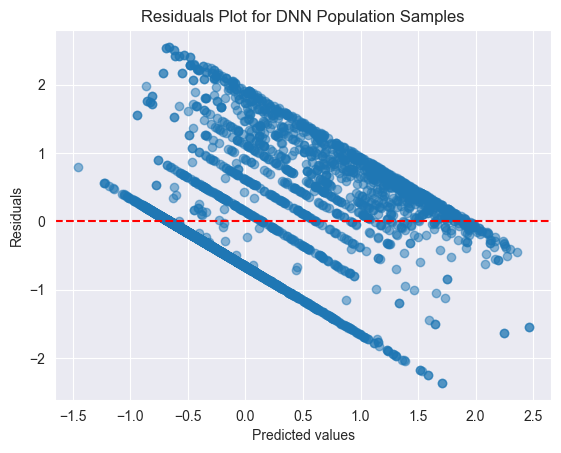

In [70]:
test_model(model_dnn_population, dnn_data_population["X_test"], dnn_data_population["y_test"], "DNN Population Samples")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R2 score for DNN Colony Samples: 0.618308744744071
MAE score for DNN Colony Samples: 0.4557464692326114


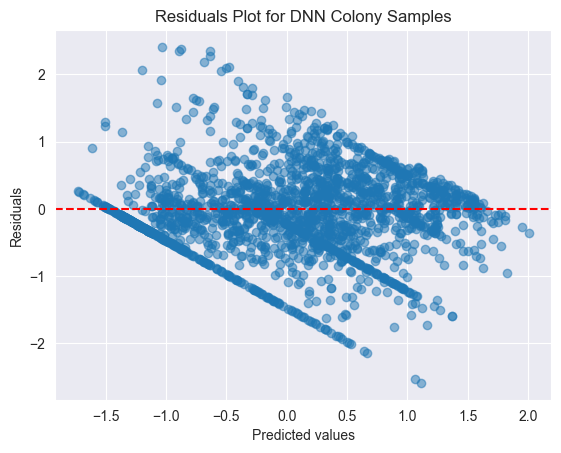

In [74]:
test_model(model_dnn_colony, dnn_data_colony["X_test"], dnn_data_colony["y_test"], "DNN Colony Samples")

## 10. Conclusions

### 10.1. Final Model Selection

- **Selected model**
Ensemble tree-based models (Random Forest and XGBoosting) were selected as the final models.
The dataset exhibits  non-linear relationships, complex interactions between environmental and geographic variables, and pronounced skewness with outliers. Ensemble tree methods handle these characteristics effectively, as they do not rely on distance-based metrics or gradient optimization that can be distorted by extreme values. In contrast, SVMs and deep neural networks showed higher sensitivity to feature scaling, skewness, and extreme observations, resulting in less stable performance.

- **Strengths and weaknesses**
The main strengths of ensemble trees include robustness to outliers, the ability to implicitly capture feature interactions without explicit feature engineering, and consistent generalization across different dataset variants. Their primary limitations are reduced interpretability compared to linear models and higher computational cost relative to simpler approaches, particularly when training large ensembles.

### 10.2. Key Findings

* Causal structure (DAG) for coral bleaching analysis:

```text
   Geography ---> Human Impact ---> Bleaching
        |              |                ∧
        |              ∨                |
        --------> Environment -----------
```

   **Geography** (e.g., distance to shore, ocean, country, depth) affects:
        - Human impact (population, fishing, pollution)
        - Environmental conditions (temperature, turbidity, light, currents)
        - Bleaching directly through natural ecological pathways

   **Human impact** also influences the environment (e.g., pollution, sedimentation), creating indirect effects on bleaching.

   To estimate the causal effect Human Impact -> Bleaching, geographic variables must be included as controls to block backdoor paths.

* Model Behavior: Support Vector Machines (SVM)

  **Scalability issues:** SVMs performed very poorly on large datasets. Training was extremely time-consuming and computationally expensive, making large-scale tuning impractical.
  **Sensitivity to multicollinearity:** The presence of highly correlated features distorted the margin geometry, resulting in unstable predictions.
  **Skewed target distribution:** SVM struggled with the heavily imbalanced Percent_Bleaching values, particularly underestimating extreme bleaching events.


* Model Behavior: Ensemble Tree Models (Random Forest & XGBoost)

    **Random Forest**

    **Robust to outliers:** Handles extreme Percent_Bleaching values well, producing more frequent but smaller errors (lower MAE).
    **Insensitive to feature selection:** Maintains stable performance even when weak or correlated predictors are removed.
    **Captures non-linear interactions:** Effectively models complex relationships between environmental and geographic variables without explicit feature engineering.
    **Computational considerations:** Training time increases with many categorical features (e.g., Realm_Name), but removing these features significantly improves efficiency.

    **XGBoost**

    **Error characteristics:** Produces fewer but larger errors, making extreme bleaching predictions slightly less reliable.
    **High predictive capability:** Achieves strong performance within the main cluster of bleaching values (0–35%).
    **Sensitive to feature engineering:** Shows larger gains from removing weak or correlated predictors compared to Random Forest.

### 10.3 Limitations

* Imbalanced data: The dataset is highly imbalanced, with a disproportionate number of non-bleaching reefs compared to fewer bleaching and severely bleached observations, which add bias toward majority patterns and makes accurate modeling of extreme bleaching events more challenging.

* Multicollinearity: Temperature-related variables (Temperature_Mean, Temperature_Maximum, ClimSST) and other correlated features exhibit high variance inflation factors (VIFs), potentially destabilizing models that assume independent predictors.

### 10.4 Future Improvements

* Feature engineering: Introduce explicit interaction terms, threshold-based features, and categorical embeddings - based on tree feature importance and permutations scores - to help deep neural networks better capture non-linear and conditional relationships in the data.

* More data:
Scraping the data sources referenced in the dataset documentation to collect additional observations, improving coverage and model generalization for moderate and severe bleached reef.

* Model tuning:
Exploit the temporal structure of the dataset by transitioning from feedforward DNNs to sequence models such as RNNs or LSTMs to better capture time-dependent bleaching dynamics. Also apply some feature engineering based on tree feature importance and permutations scores.

## 11. Appendix

### 11.1 Hyperparameters

### 11.2 Additional Plots

### 11.3 Reproducibility Notes
